In [2]:
%pylab
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate
plt.style.use('classic')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['PT Serif']})
rc('text', usetex=True)
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

Using matplotlib backend: <object object at 0x7f159c690920>
Populating the interactive namespace from numpy and matplotlib


/home/lera/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


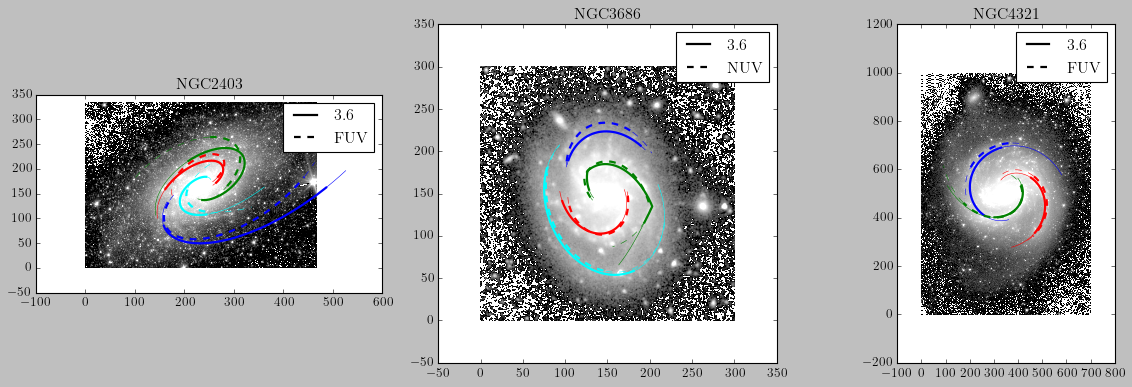

In [3]:
def parse_imfit_file(folder, path, file = "fit_sp.imfit"):
    f = open(f"{folder}/{path}/input_sp.imfit", mode='r')
    col_list = []
    for line in f:
        if line.find("#") != -1:
            if line.split()[-1] != "boundary":
                col_list.append(line.split()[-1])
    f.close()
    
    f = open(f"{folder}/{path}/{file}", mode='r')
    params_list = []
    #this_spiral = [] # r_0, phi_0, r_e, phi_e, m_2, m_3, m_4
    br = 0
    for line in f:
        if line.startswith("X0"):
            X0 = float(line.split()[1])
        if line.startswith("Y0"):
            Y0 = float(line.split()[1])
        if line.startswith("PA"):
            PA = float(line.split()[1])
        if line.startswith("ell"):
            ell = float(line.split()[1])
        if line.startswith("r_0"):
            r_0 = float(line.split()[1])
        if line.startswith("phi_0"):
            phi_0 = float(line.split()[1])
        if line.startswith("r_break_1"):
            r_br = float(line.split()[1])
            br = 1
        if line.startswith("phi_break_1"):
            phi_br = float(line.split()[1])
        if line.startswith("r_break_2"):
            r_br_2 = float(line.split()[1])
            br = 2
        if line.startswith("phi_break_2"):
            phi_br_2 = float(line.split()[1])
        if line.startswith("r_end"):
            r_e = float(line.split()[1])
        if line.startswith("phi_end"):
            phi_e = float(line.split()[1])
        if line.startswith("mu_a_2"):
            m_2 = float(line.split()[1])
        if line.startswith("mu_a_3"):
            m_3 = float(line.split()[1])
        if line.startswith("mu_a_4"):
            m_4 = float(line.split()[1])
        if line.startswith("mu_b_2"):
            m_b_2 = float(line.split()[1])
        if line.startswith("mu_b_3"):
            m_b_3 = float(line.split()[1])
        if line.startswith("mu_c_2"):
            m_c_2 = float(line.split()[1])
        if line.startswith("part_growth"):
            pg = float(line.split()[1])
        if line.startswith("part_cutoff"):
            pc = float(line.split()[1])
        if line.startswith("w_asymm"):
            w_asymm = float(line.split()[1])
        if line.startswith("gamma_out"):
            g_out = float(line.split()[1])
        if line.startswith("gamma_in"):
            g_in = float(line.split()[1])
            if br == 2:
                params_list.append([PA, ell, r_0, phi_0, r_br, phi_br, r_br_2, phi_br_2, r_e, phi_e, m_2, m_b_2, m_c_2, pg, pc, w_asymm, g_out, g_in])
            elif br == 1:
                params_list.append([PA, ell, r_0, phi_0, r_br, phi_br, r_e, phi_e, m_2, m_3, m_b_2, m_b_3, pg, pc, w_asymm, g_out, g_in])
            else:
                params_list.append([PA, ell, r_0, phi_0, r_e, phi_e, m_2, m_3, m_4, pg, pc, w_asymm, g_out, g_in])
            br = 0
        
    f.close()
    return col_list, params_list, X0, Y0

def to_cartesian(phi, r):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return (x, y)

def projection(PA, ell, x, y):
    xp = x * np.cos(PA) - (y * (1 - ell)) * np.sin(PA)
    yp = x * np.sin(PA) + (y * (1 - ell)) * np.cos(PA)
    return (xp, yp)

def find_where_symm(w_asymm, g_out, g_in):
    w_rel_c = np.log((1 + w_asymm) / (1 - w_asymm)) #at phi_norm = 0.5
    wr_rate = g_out - g_in
    if wr_rate == 0:
        return -1
    else:
        psi_n_eq = 0.5 - (w_rel_c / wr_rate)
        return psi_n_eq

def calc_k(r_0, r_e, m_2, m_3, m_4):
    m_1 = np.log(r_e / r_0)
    k_1 = m_1 - m_2 + m_3 - m_4
    k_2 = m_2 - 3 * m_3 + 6 * m_4
    k_3 = 2 * m_3 - 10 * m_4
    k_4 = 5 * m_4
    return (k_1, k_2, k_3, k_4)

def calc_shape(PA, ell, r_0, phi_0, r_e, phi_e, m_2, m_3, m_4, pg, pc, w_asymm, g_out, g_in, to_cart = True):
    k_1, k_2, k_3, k_4 = calc_k(r_0, r_e, m_2, m_3, m_4)
    psi_n_eq = find_where_symm(w_asymm, g_out, g_in)
    psi_norm = np.linspace(0, 1, 1000)
    main_part = np.where((psi_norm > pg) * (psi_norm < 1 - pc), True, False)
    phi = np.radians(psi_norm * (phi_e - phi_0) + phi_0)
    r = r_0 * np.exp(k_1 * psi_norm + k_2 * np.power(psi_norm, 2) + k_3 * np.power(psi_norm, 3) + k_4 * np.power(psi_norm, 4))
    
    if np.abs(psi_n_eq - 0.5) < 0.5:
        phiweq = np.radians(psi_n_eq * (phi_e - phi_0) + phi_0)
        rweq = r_0 * np.exp(k_1 * psi_n_eq + k_2 * np.power(psi_n_eq, 2) + k_3 * np.power(psi_n_eq, 3) + k_4 * np.power(psi_n_eq, 4))
    else:
        rweq = np.nan
        phiweq = np.nan
    
    if not to_cart:
        return (r, phi, main_part, rweq, phiweq)
    else:
        x, y = to_cartesian(phi, r)
        xp, yp = projection(np.radians(PA + 90), ell, x, y)
        return (xp, yp, main_part)
    
def calc_shape_br(PA, ell, r_0, phi_0, r_br, phi_br, r_e, phi_e, m_2, m_3, m_b_2, m_b_3, pg, pc, w_asymm, g_out, g_in, to_cart = True):
    k_1, k_2, k_3, k_4 = calc_k(r_0, r_br, m_2, m_3, 0)
    k_b_1, k_b_2, k_b_3, k_b_4 = calc_k(r_br, r_e, m_b_2, m_b_3, 0)
    psi_n_eq = find_where_symm(w_asymm, g_out, g_in)
    psi_norm_a = np.linspace(0, 1, 500)
    psi_norm_b = np.linspace(0, 1, 500)
    psi_norm = np.linspace(0, 1, 1000)
    
    main_part = np.where((psi_norm > pg) * (psi_norm < 1 - pc), True, False)
    phi_a = np.radians(psi_norm_a * (phi_br - phi_0) + phi_0)
    phi_b = np.radians(psi_norm_b * (phi_e - phi_br) + phi_br)
    r_a = r_0 * np.exp(k_1 * psi_norm_a + k_2 * np.power(psi_norm_a, 2) +
                       k_3 * np.power(psi_norm_a, 3) + k_4 * np.power(psi_norm_a, 4))
    r_b = r_br * np.exp(k_b_1 * psi_norm_b + k_b_2 * np.power(psi_norm_b, 2) +
                       k_b_3 * np.power(psi_norm_b, 3) + k_b_4 * np.power(psi_norm_b, 4))
    r = np.concatenate((r_a, r_b), axis = None)
    phi = np.concatenate((phi_a, phi_b), axis = None)
    
    if np.abs(psi_n_eq - 0.5) < 0.5:
        phiweq = np.radians(psi_n_eq * (phi_e - phi_0) + phi_0)
        iweq = np.argmin(np.abs(phi - phiweq))
        rweq = r[iweq]
        #rweq = r_0 * np.exp(k_1 * psi_n_eq + k_2 * np.power(psi_n_eq, 2) + k_3 * np.power(psi_n_eq, 3) + k_4 * np.power(psi_n_eq, 4))
    else:
        rweq = np.nan
        phiweq = np.nan
    
    if not to_cart:
        return (r, phi, main_part, rweq, phiweq)
    else:
        x, y = to_cartesian(phi, r)
        xp, yp = projection(np.radians(PA + 90), ell, x, y)
        return (xp, yp, main_part)
    
def calc_shape_br2(PA, ell, r_0, phi_0, r_br, phi_br, r_br_2, phi_br_2, r_e, phi_e, m_2, m_b_2, m_c_2, pg, pc, w_asymm, g_out, g_in, to_cart = True):
    k_1, k_2, k_3, k_4 = calc_k(r_0, r_br, m_2, 0, 0)
    k_b_1, k_b_2, k_b_3, k_b_4 = calc_k(r_br, r_br_2, m_b_2, 0, 0)
    k_c_1, k_c_2, k_c_3, k_c_4 = calc_k(r_br_2, r_e, m_c_2, 0, 0)
    psi_n_eq = find_where_symm(w_asymm, g_out, g_in)
    psi_norm_a = np.linspace(0, 1, 300)
    psi_norm_b = np.linspace(0, 1, 400)
    psi_norm_c = np.linspace(0, 1, 300)
    psi_norm = np.linspace(0, 1, 1000)
    
    main_part = np.where((psi_norm > pg) * (psi_norm < 1 - pc), True, False)
    phi_a = np.radians(psi_norm_a * (phi_br - phi_0) + phi_0)
    phi_b = np.radians(psi_norm_b * (phi_br_2 - phi_br) + phi_br)
    phi_c = np.radians(psi_norm_c * (phi_e - phi_br_2) + phi_br_2)
    r_a = r_0 * np.exp(k_1 * psi_norm_a + k_2 * np.power(psi_norm_a, 2) +
                       k_3 * np.power(psi_norm_a, 3) + k_4 * np.power(psi_norm_a, 4))
    r_b = r_br * np.exp(k_b_1 * psi_norm_b + k_b_2 * np.power(psi_norm_b, 2) +
                       k_b_3 * np.power(psi_norm_b, 3) + k_b_4 * np.power(psi_norm_b, 4))
    r_c = r_br_2 * np.exp(k_c_1 * psi_norm_c + k_c_2 * np.power(psi_norm_c, 2) +
                       k_c_3 * np.power(psi_norm_c, 3) + k_c_4 * np.power(psi_norm_c, 4))
    r = np.concatenate((r_a, r_b, r_c), axis = None)
    phi = np.concatenate((phi_a, phi_b, phi_c), axis = None)
    
    if np.abs(psi_n_eq - 0.5) < 0.5:
        phiweq = np.radians(psi_n_eq * (phi_e - phi_0) + phi_0)
        iweq = np.argmin(np.abs(phi - phiweq))
        rweq = r[iweq]
        #rweq = r_0 * np.exp(k_1 * psi_n_eq + k_2 * np.power(psi_n_eq, 2) + k_3 * np.power(psi_n_eq, 3) + k_4 * np.power(psi_n_eq, 4))
    else:
        rweq = np.nan
        phiweq = np.nan
    
    if not to_cart:
        return (r, phi, main_part, rweq, phiweq)
    else:
        x, y = to_cartesian(phi, r)
        xp, yp = projection(np.radians(PA + 90), ell, x, y)
        return (xp, yp, main_part)

gals = ["NGC2403", "NGC3686", "NGC4321"]

plt.figure(figsize=[15,5])
for j in range(len(gals)):
    plt.subplot(1, 3, j + 1)
    gal = gals[j]
    NIR = "3.6"
    UV = "FUV"
    if gal == "NGC3686":
        UV = "NUV"
        uv_sc = 1.5
        #UV = "FUV"
        #uv_sc = 3.2
        #NIR = "3.6_stellar"
    else:
        uv_sc = 1.5
    
    cols, params, X0, Y0 = parse_imfit_file('./decomposition', f"{gal}/{NIR}")
    image = fits.getdata(f"decomposition/{gal}/{NIR}/image.fits")
    
    for band in [NIR, UV]:
        cols, params, _, _ = parse_imfit_file("decomposition", f"{gal}/{band}")
        if band == NIR:
            ls = "-"
            scale = 1
        else:
            ls = "--"
            scale = uv_sc / 0.75
        for i in range(len(cols)):
            col = cols[i]
            pars_this = params[i]
            if len(pars_this) == 14:
                xp, yp, main_part = calc_shape(*pars_this)
            elif len(pars_this) == 17:
                xp, yp, main_part = calc_shape_br(*pars_this)
            else:
                xp, yp, main_part = calc_shape_br2(*pars_this)
            xp = xp * scale
            yp = yp * scale
            xpout = np.where(~main_part, xp, np.nan)
            ypout = np.where(~main_part, yp, np.nan)
            plt.plot(xpout + X0, ypout + Y0, c = col, ls=ls, lw = 0.5)
            plt.plot(xp[main_part] + X0, yp[main_part] + Y0, c = col, ls=ls, lw = 2)
    plt.title(gal)
    vmax = np.quantile(image, 0.98)
    plt.imshow(image, norm=LogNorm(vmin=vmax/100, vmax=vmax), origin='lower', cmap = 'gray')
    plt.plot([], [], c = "k", ls = "-", lw = 2, label = NIR)
    plt.plot([], [], c = "k", ls = "--", lw = 2, label = UV)
    plt.legend()
plt.tight_layout()
plt.savefig("overlay", dpi = 300)
plt.show()

In [4]:
def draw_r_phi(folder, gal, NIR, nir_sc, UV, uv_sc, col_exc):
    plt.figure(figsize=[10,4])
    cols, params, X0, Y0 = parse_imfit_file(folder, f"{gal}/{NIR}")

    for band in [NIR, UV]:
        cols, params, _, _ = parse_imfit_file(folder, f"{gal}/{band}")
        #print(params)
        if band == NIR:
            #cols, params, _, _ = parse_imfit_file(f"{gal}/{band}", file = "i")
            ls = "-"
            scale = nir_sc
        else:
            ls = "--"
            scale = uv_sc
        for i in range(len(cols)):
            col = cols[i]
            if col in col_exc:
                continue
            pars_this = params[i]
            if len(pars_this) == 14:
                r, phi, main_part, rweq, phiweq = calc_shape(*pars_this, to_cart = False)
            elif len(pars_this) == 17:
                r, phi, main_part, rweq, phiweq = calc_shape_br(*pars_this, to_cart = False)
            else:
                r, phi, main_part, rweq, phiweq = calc_shape_br2(*pars_this, to_cart = False)
            r = r * scale
            phi = np.degrees(phi)
            rweq = rweq * scale
            phiweq = np.degrees(phiweq)
            rout = np.where(~main_part, r, np.nan)
            phiout = np.where(~main_part, phi, np.nan)
            plt.plot(phiout, rout, c = col, ls=ls, lw = 0.5)
            plt.plot(phi[main_part], r[main_part], c = col, ls=ls, lw = 2)
            plt.scatter(phiweq, rweq, c = col, marker = "x", s = 50)
    plt.title(gal)
    vmax = np.quantile(image, 0.98)
    #plt.imshow(image, norm=LogNorm(vmin=vmax/100, vmax=vmax), origin='lower', cmap = 'gray')
    plt.plot([], [], c = "k", ls = "-", lw = 2, label = NIR)
    plt.plot([], [], c = "k", ls = "--", lw = 2, label = UV)
    plt.scatter(np.nan, np.nan, c = "k", marker = "x", s = 50, label = "w_out = w_in")
    plt.legend()
    plt.xlabel("phi, deg")
    plt.ylabel("r, arcsec")
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig("overlay", dpi = 300)
    plt.show()

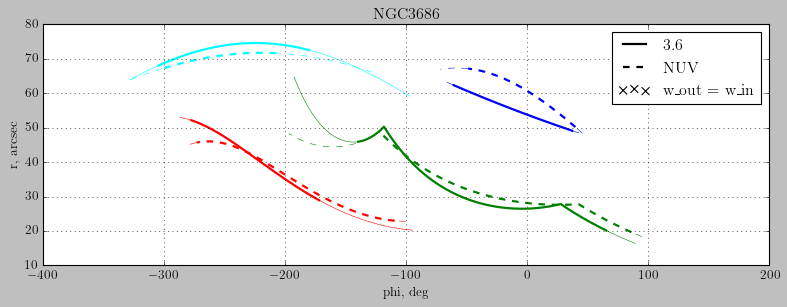

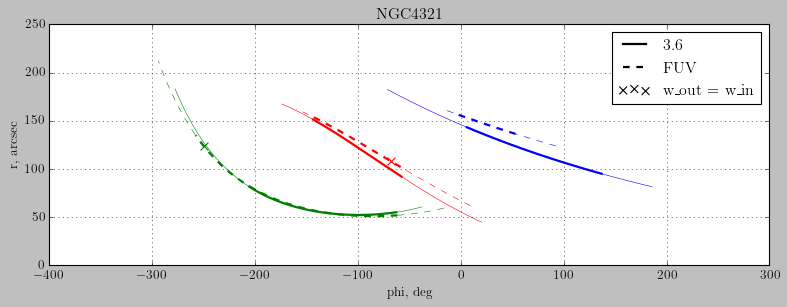

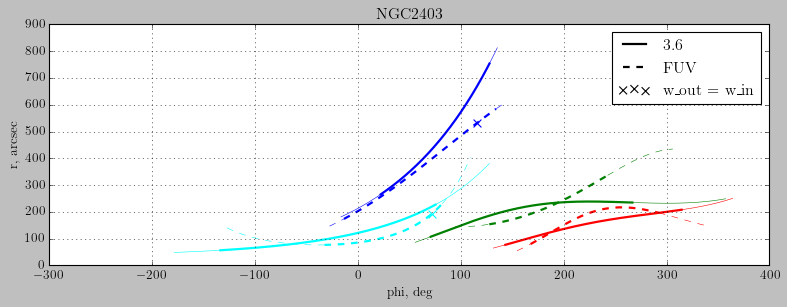

In [5]:
folder = "decomposition"
gal = "NGC3686"
NIR = "3.6"
nir_sc = 0.75
UV = "NUV"
uv_sc = 1.5
col_exc = ["cyan", "blue"] #these ones are secondary anyway
col_exc = []
draw_r_phi(folder, gal, NIR, nir_sc, UV, uv_sc, col_exc)

#UV = "FUV_orig"
#draw_r_phi(folder, gal, NIR, nir_sc, UV, uv_sc, col_exc)

folder = "decomposition"
gal = "NGC4321"
NIR = "3.6"
nir_sc = 0.75
UV = "FUV"
uv_sc = 1.5
col_exc = []
#col_exc = ["cyan", "blue"]
draw_r_phi(folder, gal, NIR, nir_sc, UV, uv_sc, col_exc)

folder = "decomposition"
gal = "NGC2403"
NIR = "3.6"
nir_sc = 0.75 * 3
UV = "FUV"
uv_sc = 1.5 * 3
col_exc = []
draw_r_phi(folder, gal, NIR, nir_sc, UV, uv_sc, col_exc)

In [6]:
def get_deltaphi(folder, gal, NIR, nir_sc, UV, uv_sc, color, bounds_phi,bounds_r,rad_step):
    plt.figure(figsize=[10,4])
    cols, params, X0, Y0 = parse_imfit_file(folder, f"{gal}/{NIR}")
    
    for band in [NIR, UV]:
        if band == NIR:
            r_NIR = np.zeros(1000)
            phi_NIR = np.zeros(1000)
        else:
            r_UV = np.zeros(1000)
            phi_UV = np.zeros(1000)
        cols, params, _, _ = parse_imfit_file(folder, f"{gal}/{band}")
        for i in range(len(cols)):
            if cols[i] == color:
                pars_this = params[i]
                if len(pars_this) == 14:
                    r, phi, main_part, rweq, phiweq = calc_shape(*pars_this, to_cart = False)
                elif len(pars_this) == 17:
                    r, phi, main_part, rweq, phiweq = calc_shape_br(*pars_this, to_cart = False)
                else:
                    r, phi, main_part, rweq, phiweq = calc_shape_br2(*pars_this, to_cart = False)
                if band == NIR:
                    scale = nir_sc
                    r_ = r * scale
                    phi = np.degrees(phi)
                    rweq = rweq * scale
                    phiweq = np.degrees(phiweq)
                    r_NIR[:] = r_
                    phi_NIR[:] = phi

                else:
                    scale = uv_sc
                    r_ = r * scale
                    phi = np.degrees(phi)
                    rweq = rweq * scale
                    phiweq = np.degrees(phiweq)
                    r_UV[:] = r_
                    phi_UV[:] = phi

    
    
    mask_NIR = (phi_NIR[:]>bounds_phi[0]) & (phi_NIR[:]<bounds_phi[1])
    mask_UV = (phi_UV[:]>bounds_phi[0]) & (phi_UV[:]<bounds_phi[1])
    
    soft_par = 170
  
    t, c, k = interpolate.splrep(r_NIR[:][mask_NIR],phi_NIR[:][mask_NIR], s=soft_par, k=3)
    spline_IR = interpolate.BSpline(t, c, k, extrapolate=True)

    t, c, k = interpolate.splrep(r_UV[:][mask_UV],phi_UV[:][mask_UV], s=soft_par, k=3)
    spline_FUV = interpolate.BSpline(t, c, k, extrapolate=True)
    
#     plt.plot(phi_NIR[:],r_NIR[:])
#     plt.plot(phi_UV[:],r_UV[:])
    
#     plt.plot(phi_NIR[:][mask_NIR],r_NIR[:][mask_NIR])
#     plt.plot(phi_UV[:][mask_UV],r_UV[:][mask_UV])
    if  bounds_r[1]>bounds_r[0]:   
        points = np.arange(bounds_r[0],bounds_r[1],rad_step)
    else:
        points = np.arange(bounds_r[0],bounds_r[1],-rad_step)
    deltaphi = spline_FUV(points)-spline_IR(points)
    
    return points,deltaphi

### NGC3686

/tmp/ipykernel_7422/2125916437.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  omega = velocity_approx_p(x)/x


32.90414766322728 0.9822133630814122 0.39288534523256485


<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

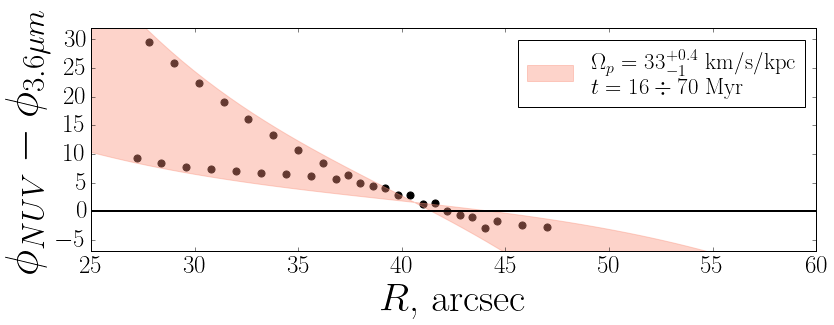

In [54]:
galname='NGC3686'
nir_sc = 0.75
uv_sc = 1.5
deg = 4
Mpc=21
Omega= 3.35
Omega_err = [3.25,3.39]
cr1=42.5
vel = np.load(f'./../F-B method/kinematics/{galname}_vel.npy')
rad = np.load(f'./../F-B method/kinematics/{galname}_rad.npy')

def velocity_approx(x, a, b, c):
            return a * x**2/(b**2+x**2)+c
    
velocity_approx_p = np.poly1d(np.polyfit(rad, vel, deg=deg))    
p_vel, param_cov = curve_fit(velocity_approx, rad, vel)
points = np.linspace(min(rad), max(rad)+5, 100)

r_1, offset_1 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'NUV', uv_sc, 'red', [-250,-110],[44,27],1.2)
r_2, offset_2 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'NUV', uv_sc, 'green', [-105,-40],[47,27],1.2)
# shift_obs = np.concatenate([r_1, r_2])
# rad_obs = np.concatenate([offset_1, offset_2])

def theory_curve(x,t,Omega_p):
    # scale = np.pi / (180 * 3600) * Mpc * 10**3
    # omega = velocity_approx(x,p_vel[0],p_vel[1],p_vel[2])/x
    # return (omega/scale-Omega_p/scale)*t*180./np.pi*0.00102
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    omega = velocity_approx_p(x)/x
    return (omega/scale-Omega_p/scale)*t*180./np.pi*0.00102

# p, param_cov = curve_fit(theory_curve, rad_obs, shift_obs)
scale = np.pi / (180 * 3600) * Mpc * 10**3

fig = plt.figure(figsize=[13,4])
plt.scatter(r_1, offset_1,50, color='k')
plt.scatter(r_2, offset_2 ,50, color='k')

# print(p[0],p[1]*scale)
# theory_ = [theory_curve(r, p[0], p[1]) for r in points]
# theory_l = [theory_curve(r, p[0]-1, 3.2) for r in points]
# theory_r = [theory_curve(r, p[0]+1, 3.8) for r in points]

theory_ = [theory_curve(r, 32., Omega) for r in points]
theory_l = [theory_curve(r, 15., Omega-0.1) for r in points]
theory_r = [theory_curve(r, 70., Omega+0.04) for r in points]

print(Omega/scale, (Omega-Omega_err[0])/scale, (Omega_err[1]-Omega)/scale)

plt.fill_between(points,theory_l ,theory_r,color='#fb917b',alpha=0.4, label=r'$\Omega_p = 33^{+0.4}_{-1}$ km/s/kpc '+ "\n"  +  r' $t=16 \div 70$ Myr')

# plt.plot(points,theory_,color='#9e221e', label=r'$\Omega_p = 43^{+'+str(int(5))+'}_{-'+str(int(5))+'}$ km/s/kpc '+ "\n"  +  r' $t=22^{+2}_{-2}$ Myr',lw=2 )


# plt.axvline(x=cr1, color='#ca6e5e',linestyle='--', label=r'$R_c = 42.5^{+2}_{-1}$ arcsec')
# plt.axvspan(cr1-1,cr1+2,color='#ffd7cd',alpha=0.4)
plt.axhline(y=0,color='black',lw=2)
plt.fill_between([-20, 20], [40,40],[-15,-15],color ='#8c5e78', hatch='/',facecolor='none', alpha=1)
plt.xlabel(r'$R$, arcsec', fontsize=40)
plt.ylabel(r'$\phi_{NUV}-\phi_{3.6 \mu m}$',  fontsize=45)
plt.legend(fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(25,60)
plt.ylim(-7,32)
plt.savefig(f'./../../individual galaxies/{galname}/{galname}_offset.png',transparent = False, dpi=250, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### NGC2403

26.904105162664738 1.2811478648887948 1.9217217973331975
46.761897068441094 1.9217217973331975 3.2028696622219957


(-22.0, 60.0)

<Figure size 800x320 with 0 Axes>

<Figure size 800x320 with 0 Axes>

<Figure size 800x320 with 0 Axes>

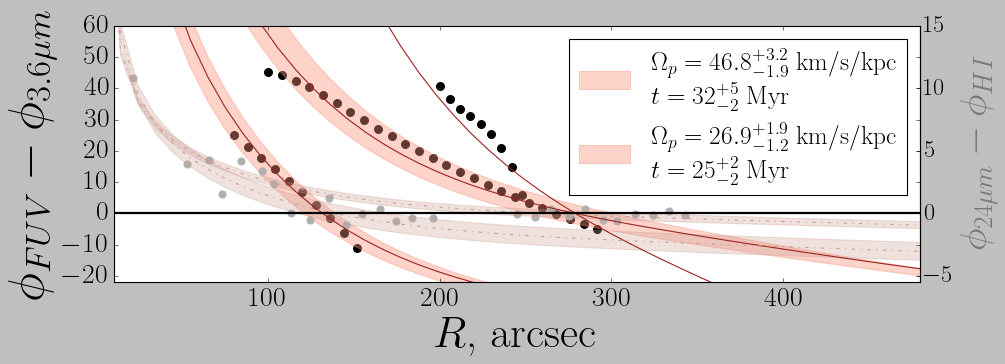

In [13]:
galname='NGC2403'
nir_sc = 0.75*3.2
uv_sc = 1.5*3.2
deg = 7
Mpc=3.22
Omega1 = 0.42
Omega1_err = [0.4,0.45]
Omega2= 0.73
Omega2_err = [0.7,0.78]
t1=32
t2=25
t3=90
cr1=42.5
vel = np.load(f'./../F-B method/kinematics/{galname}_vel.npy')
rad = np.load(f'./../F-B method/kinematics/{galname}_rad.npy')

data = np.loadtxt('./../../individual galaxies/NGC2403/NGC2403_THINGS.dat')

vel = np.abs(data[:,1])
rad = np.abs(data[:,0])

def velocity_approx(x, a, b, c):
            return a * x**2/(b**2+x**2)+c
    
velocity_approx_p = np.poly1d(np.polyfit(rad, vel, deg=deg))    
p_vel, param_cov = curve_fit(velocity_approx, rad, vel)
points = np.linspace(min(rad), max(rad)+30, 100)

r_1, offset_1 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'FUV', uv_sc, 'red', [170,240],[80,160],8)
r_2, offset_2 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'FUV', uv_sc, 'cyan', [0,100],[100,300],8)
r_3, offset_3 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'FUV', uv_sc, 'green', [140,190],[200,250],6)
shift_obs = np.concatenate([r_1, r_2])
rad_obs = np.concatenate([offset_1, offset_2])

def theory_curve(x,t,Omega_p):
    # scale = np.pi / (180 * 3600) * Mpc * 10**3*3
    # omega = velocity_approx(x,p_vel[0],p_vel[1],p_vel[2])/x
    # return (omega/scale-Omega_p/scale)*t*180./np.pi*0.00102
    scale = np.pi / (180 * 3600) * Mpc * 10**3
    omega = velocity_approx_p(x)/x
    return (omega/scale-Omega_p/scale)*t*180./np.pi*0.00102

scale = np.pi / (180 * 3600) * Mpc * 10**3

fig, ax = plt.subplots(figsize=[13,4])
plt.scatter(r_1, offset_1,50, color='k')
plt.scatter(r_2, offset_2 ,50, color='k')
plt.scatter(r_3, offset_3 ,50, color='k')

theory_1 = [theory_curve(r, t1, Omega1) for r in points]
theory_2 = [theory_curve(r, t2, Omega2) for r in points]
theory_3 = [theory_curve(r, t3, Omega1) for r in points]
theory_l1 = [theory_curve(r, t1+5, Omega1_err[0]) for r in points]
theory_l2 = [theory_curve(r, t2+2, Omega2_err[0]) for r in points]
theory_r1 = [theory_curve(r, t1-2, Omega1_err[1]) for r in points]
theory_r2 = [theory_curve(r, t2-2, Omega2_err[1]) for r in points]

print(Omega1/scale, (Omega1-Omega1_err[0])/scale, (Omega1_err[1]-Omega1)/scale)
print(Omega2/scale, (Omega2-Omega2_err[0])/scale, (Omega2_err[1]-Omega2)/scale)

plt.fill_between(points,theory_l1 ,theory_r1,color='#fb917b',alpha=0.4, label=r'$\Omega_p = 46.8^{+3.2}_{-1.9}$ km/s/kpc '+ "\n"  +  r' $t=32^{+5}_{-2}$ Myr')
plt.fill_between(points,theory_l2 ,theory_r2,color='#fb917b',alpha=0.4, label=r'$\Omega_p = 26.9^{+1.9}_{-1.2}$ km/s/kpc '+ "\n"  +  r' $t=25^{+2}_{-2}$ Myr')
# plt.fill_between(points,theory_l2 ,theory_r2,color='#fb917b',alpha=0.4)

plt.plot(points,theory_1,color='#9e221e')
plt.plot(points,theory_2,color='#9e221e')
plt.plot(points,theory_3,color='#9e221e')

######plot points from Tamburro
Omega_p1 = 0.44
Omega_p2 = 0.70
t1=1.5
t2=1.9

cr1 = 145
cr2 = 285
data_offset = np.loadtxt('./../../individual galaxies/NGC2403/NGC2403_offset.dat')

phi = data_offset[:,1]
R_kpc =  data_offset[:,0]
scale_loc = np.pi / (180 * 3600) * Mpc * 10**3
R_arcsec = R_kpc/scale_loc

omega = [v/r for r,v in zip(points, velocity_approx_p(points))] 
   
plt.scatter(R_arcsec, phi*4,40, marker='o', color='#b0b0b0')
delta_phi_theor1 = (np.array(omega)/scale-np.array(Omega_p1)/scale)*t1*180./np.pi*0.00102
delta_phi_theor2 = (np.array(omega)/scale-np.array(Omega_p2)/scale)*t2*180./np.pi*0.00102
delta_phi_theor1_r = (np.array(omega)/scale-np.array(Omega_p1+0.05)/scale)*(t1)*180./np.pi*0.00102
delta_phi_theor1_l = (np.array(omega)/scale-np.array(Omega_p1-0.05)/scale)*(t1)*180./np.pi*0.00102
delta_phi_theor2_r = (np.array(omega)/scale-np.array(Omega_p2+0.1)/scale)*(t2)*180./np.pi*0.00102
delta_phi_theor2_l = (np.array(omega)/scale-np.array(Omega_p2-0.1)/scale)*(t2)*180./np.pi*0.00102

delta_phi_theor3 = (np.array(omega)/scale-np.array(Omega_p1)/scale)*t3*180./np.pi*0.00102
# plt.axvline(x=cr1, color='#ca6e5e',linestyle='--')
# plt.axvline(x=cr2, color='#ca6e5e',linestyle='--')
# plt.axvspan(cr1-30,cr1+30,color='#ffd7cd',alpha=0.6)
# plt.axvspan(cr2-25, cr2+25,color='#ffd7cd',alpha=0.6)
plt.fill_between(points,delta_phi_theor1_l*4 ,delta_phi_theor1_r*4 ,color='#ca9c91',alpha=0.3)
plt.fill_between(points,delta_phi_theor2_l*4,delta_phi_theor2_r*4 ,color='#ca9c91',alpha=0.3)
plt.plot(points,delta_phi_theor1*4 ,'-.', color='#ca9c91')#, label=r'$\Omega_p =$ '+str(int(Omega_p1/scale))+'$\pm$'+str(int(0.06/scale))+' km/s/kpc '+ "\n"+r'($R_c =$'+str(int(cr2))+'$\pm$'+str(int(25))+'") ' + r' $t=1.5$ Myr',lw=2 )
plt.plot(points,delta_phi_theor2*4 ,'-.', color='#ca9c91')#, label=r'$\Omega_p =$ '+str(int(Omega_p2/scale))+'$\pm$'+str(int(0.1/scale))+' km/s/kpc '+ "\n"+r'($R_c =$'+str(int(cr1))+'$\pm$'+str(int(30))+'") ' + r' $t=1.9$ Myr' ,lw=2)
def to_Tamburro(x):
    return x * 4


def from_Tamburro(x):
    return x/4


secax_y = ax.secondary_yaxis(
    'right', functions=(from_Tamburro, to_Tamburro))
secax_y.set_ylabel(r'$\phi_{24\mu m}-\phi_{HI}$', fontsize=35,color='#7a7774')
# secax_y.set_ylabel.set_color('red')
secax_y.tick_params(axis='both', which='major', labelsize=22)

#################
# plt.axvline(x=cr1, color='#ca6e5e',linestyle='--')
# plt.axvspan(cr1-1,cr1+2,color='#ffd7cd',alpha=0.6)
plt.axhline(y=0,color='black',lw=2)
plt.xlabel(r'$R$, arcsec', fontsize=40)
plt.ylabel(r'$\phi_{FUV}-\phi_{3.6 \mu m}$',  fontsize=45)
plt.legend(fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(10,480)
plt.ylim(-22,60)
# plt.savefig(f'./../../individual galaxies/{galname}/{galname}_offset.png',transparent = False, dpi=250, bbox_inches='tight', pad_inches=0.05, facecolor='white')

### NGC4321

20.756206917946805 7.783577594230052 14.26989225608843


<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

<Figure size 720x288 with 0 Axes>

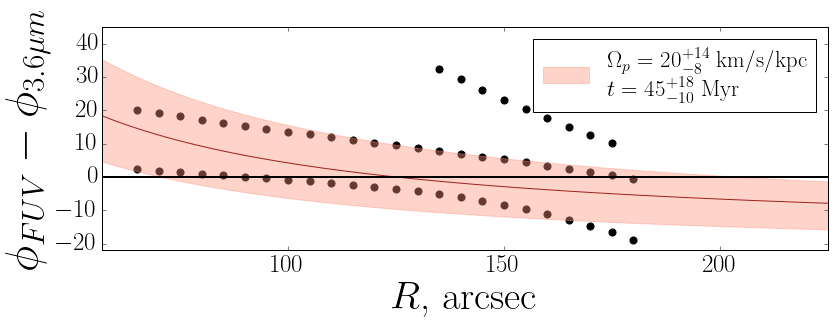

In [52]:
galname='NGC4321'
nir_sc = 0.75
uv_sc = 1.5
deg = 3
Mpc=15.9
Omega1 = 1.6
Omega1_err = [1.,2.7]
# Omega2= 0.73
# Omega2_err = [0.7,0.78]
t1=45
# t2=32
# cr1=42.5
vel = np.load(f'./../F-B method/kinematics/{galname}_vel.npy')
rad = np.load(f'./../F-B method/kinematics/{galname}_rad.npy')
# data = np.loadtxt('./../../individual galaxies/NGC2403/NGC2403_THINGS.dat')

# vel = np.abs(data[:,1])
# rad = np.abs(data[:,0])

def velocity_approx(x, a, b, c):
            return a * x**2/(b**2+x**2)+c
    
velocity_approx_p = np.poly1d(np.polyfit(rad, vel, deg=deg))    
p_vel, param_cov = curve_fit(velocity_approx, rad, vel)
points = np.linspace(min(rad), max(rad)+100, 100)

# fig = plt.figure(figsize=[13,4])
# plt.plot(rad,vel,'o')
# plt.plot(points,velocity_approx_p(points))
# plt.plot(points,velocity_approx(points,p_vel[0],p_vel[1],p_vel[2]))

r_1, offset_1 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'FUV', uv_sc, 'red', [-150,0],[180,60],5)
r_2, offset_2 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'FUV', uv_sc, 'blue', [0,80],[175,130],5)
r_3, offset_3 = get_deltaphi('decomposition', galname, '3.6', nir_sc, 'FUV', uv_sc, 'green', [-250,-150],[180,60],5)
# shift_obs = np.concatenate([r_1, r_2])
# rad_obs = np.concatenate([offset_1, offset_2])

def theory_curve(x,t,Omega_p):
    scale = np.pi / (180 * 3600) * Mpc * 10**3*3
    omega = velocity_approx(x,p_vel[0],p_vel[1],p_vel[2])/x
    return (omega/scale-Omega_p/scale)*t*180./np.pi*0.00102
    # scale = np.pi / (180 * 3600) * Mpc * 10**3
    # omega = velocity_approx_p(x)/x
    # return (omega/scale-Omega_p/scale)*t*180./np.pi*0.00102

# p, param_cov = curve_fit(theory_curve, r_2, offset_2)
# print(p)
scale = np.pi / (180 * 3600) * Mpc * 10**3

fig = plt.figure(figsize=[13,4])
plt.scatter(r_1, offset_1,50, color='k')
plt.scatter(r_2, offset_2 ,50, color='k')
plt.scatter(r_3, offset_3 ,50, color='k')

# print(p[0],p[1]*scale)
# theory_ = [theory_curve(r, p[0], p[1]) for r in points]
# theory_l = [theory_curve(r, p[0]-1, 3.2) for r in points]
# theory_r = [theory_curve(r, p[0]+1, 3.8) for r in points]

theory_1 = [theory_curve(r, t1, Omega1) for r in points]
# theory_2 = [theory_curve(r, t2, Omega2) for r in points]
theory_l1 = [theory_curve(r, t1+18, Omega1_err[0]) for r in points]
# theory_l2 = [theory_curve(r, t2+2, Omega2_err[0]) for r in points]
theory_r1 = [theory_curve(r, t1-10, Omega1_err[1]) for r in points]
# theory_r2 = [theory_curve(r, t2-2, Omega2_err[1]) for r in points]

print(Omega1/scale, (Omega1-Omega1_err[0])/scale, (Omega1_err[1]-Omega1)/scale)
# print(Omega2/scale, (Omega2-Omega2_err[0])/scale, (Omega2_err[1]-Omega2)/scale)

plt.fill_between(points,theory_l1 ,theory_r1,color='#fb917b',alpha=0.4, label=r'$\Omega_p = 20^{+14}_{-8}$ km/s/kpc '+ "\n"  +  r' $t=45^{+18}_{-10}$ Myr')
# plt.fill_between(points,theory_l2 ,theory_r2,color='#dd9181',alpha=0.3, label=r'$\Omega_p = 26.9^{+1.9}_{-1.2}$ km/s/kpc '+ "\n"  +  r' $t=32^{+2}_{-2}$ Myr')


plt.plot(points,theory_1,color='#9e221e')
# plt.plot(points,theory_2,color='#9e221e')


# plt.axvline(x=cr1, color='#ca6e5e',linestyle='--')
# plt.axvspan(cr1-1,cr1+2,color='#ffd7cd',alpha=0.6)
plt.axhline(y=0,color='black',lw=2)
plt.xlabel(r'$R$, arcsec', fontsize=40)
plt.ylabel(r'$\phi_{FUV}-\phi_{3.6 \mu m}$',  fontsize=45)
plt.legend(fontsize=23)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(57,225)
plt.ylim(-22,45)
plt.savefig(f'./../../individual galaxies/{galname}/{galname}_offset.png',transparent = False, dpi=250, bbox_inches='tight', pad_inches=0.05, facecolor='white')